# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: ** This is classification, because the data is discrete.  Either the students need help or they don't.

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = student_data.shape[0]

# TODO: Calculate number of features
n_features = student_data.shape[1]-1 # don't count 'passed' as a feature

# TODO: Calculate passing students
student_data.loc[student_data['passed'] == 'yes', 'passed'] = 1
student_data.loc[student_data['passed'] == 'no', 'passed'] = 0
n_passed = sum(student_data['passed'])

# TODO: Calculate failing students
n_failed = n_students - n_passed

# TODO: Calculate graduation rate
grad_rate = n_passed/float(n_students)*100

# Print the results
print("Total number of students: {}".format(n_students))
print("Number of features: {}".format(n_features))
print("Number of students who passed: {}".format(n_passed))
print("Number of students who failed: {}".format(n_failed))
print("Graduation rate of the class: {:.2f}%".format(grad_rate))

# benchmark for predicting 'yes' on all students
from sklearn.metrics import f1_score
print("\nF1 score for all 'yes' on students: {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, 
             pos_label='yes', average='binary')))



Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%

F1 score for all 'yes' on students: 0.8030


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed'],
      dtype='object')


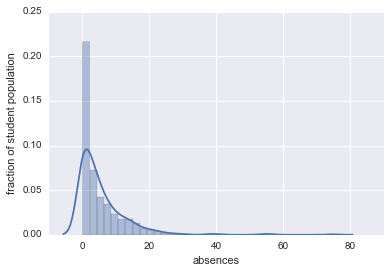

In [3]:
import seaborn as sns
import pylab as plt
%matplotlib inline
print(student_data.columns)
sns.distplot(student_data['absences'])
plt.ylabel('fraction of student population')

## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print("Feature columns:\n{}".format(feature_cols))
print("\nTarget column: {}".format(target_col))

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print("\nFeature values:")
print(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# TODO: Import any additional functionality you may need here

# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
# one way to skin a cat:
'''from sklearn.cross_validation import ShuffleSplit
rs = list(ShuffleSplit(n = X_all.shape[0], test_size = num_train, stratify=y_all, random_state = 42))

testIdx = rs[0][0]
trainIdx = rs[0][1]
X_train = X_all.iloc[trainIdx, :].values
X_test = X_all.iloc[testIdx, :].values
y_train = y_all.iloc[trainIdx].values
y_test = y_all.iloc[testIdx].values
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')


# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("Grad rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print("Grad rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))'''

#better way
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, stratify=y_all, test_size=0.24, random_state=42)

X_train = X_train.values
y_train = y_train.values.astype('int64')
X_test = X_test.values
y_test = y_test.values.astype('int64')

print("Grad rate of the training set: {:.2f}%".format(100 * (y_train == 1).mean()))
print("Grad rate of the testing set: {:.2f}%".format(100 * (y_test == 1).mean()))

Grad rate of the training set: 67.00%
Grad rate of the testing set: 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

**Answer: ** Decision trees, naive bayes, and SVMs are three supervised models that will work.  Decision trees can be used for classification and regression.  Naive Bayes models can be used for classification, and SVMs can be used for classification, regression, and outlier detection.  

DTs are easy to understand, require little data preparation, are O(log(n)) in training time and space, can handle multi-output problems, and can handle numeric and categorical data.  Weaknesses of DTs include overfitting, can be unstable if not used in an ensemble, XOR, parity, and multiplexer problems are hard for them to learn, and the dataset should be balanced before fitting the tree.

Naive Bayes only requires a small amount of training data to estimate parameters for classification.  These models can be extremely fast.  The class conditional features are decoupled, meaning that each distribution can be independently estimated.  This gives an advantage over other methods that suffer from the curse of dimensionality.  However, NB classifiers are not known to be very good classifiers, only decent.

SVMs are effective in high dimensional spaces, is versatile because different kernal functions can be used, and is memory efficient because it uses a subset of training points in the decision function.  However, if the number of features is much greater than the number of samples, it will likely give poor performance, and SVMs do not provide probability estimates directly, but use a five-fold cross-validation.

I chose these models because I know they can all be used for classification and have a diversity of strengths and weaknesses.  There are a lot of dimensions to the data, for which SVMs and NB have some advantages.  DTs are pretty easy to use.

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [7]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print("Made predictions in {:.4f} seconds.".format(end - start))
    return f1_score(target, y_pred, pos_label=1)


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print("F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train)))
    print("F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test)))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [8]:
# TODO: Import the three supervised learning models from sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# TODO: Initialize the three models
clf_A = svm.SVC(random_state=42)
clf_B = GaussianNB()
clf_C = DecisionTreeClassifier(random_state=42)

# TODO: Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
# train_predict(clf, X_train, y_train, X_test, y_test)
for clf in [clf_A, clf_B, clf_C]:
    print(clf.__class__.__name__)
    for X, Y in [(X_train_100, y_train_100), (X_train_200, y_train_200), (X_train_300, y_train_300)]:
        train_predict(clf, X, Y, X_test, y_test)
        print('')
        print('')

SVC
Training a SVC using a training set size of 100. . .
Trained model in 0.0041 seconds
Made predictions in 0.0024 seconds.
F1 score for training set: 0.8354.
Made predictions in 0.0021 seconds.
F1 score for test set: 0.8025.


Training a SVC using a training set size of 200. . .
Trained model in 0.0092 seconds
Made predictions in 0.0070 seconds.
F1 score for training set: 0.8431.
Made predictions in 0.0033 seconds.
F1 score for test set: 0.8105.


Training a SVC using a training set size of 300. . .
Trained model in 0.0170 seconds
Made predictions in 0.0140 seconds.
F1 score for training set: 0.8664.
Made predictions in 0.0047 seconds.
F1 score for test set: 0.8052.


GaussianNB
Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0016 seconds
Made predictions in 0.0005 seconds.
F1 score for training set: 0.7752.
Made predictions in 0.0005 seconds.
F1 score for test set: 0.6457.


Training a GaussianNB using a training set size of 200. . .
Trained model in 0

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - SVC**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               | 0.0242 seconds  |  0.0027 seconds |   0.8354   |    0.8025    |
| 200               |  0.0108 seconds      |   0.0036 seconds      |   0.8431      |    0.8105     |
| 300               |     0.0179 seconds       |   0.0045 seconds      |    0.8664     |    0.8052      |

** Classifer 2 - Gaussian Naive Bayes**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |     0.0011 seconds      |    0.0004 seconds     |    0.7752    |    0.6457    |
| 200               |     0.0012 seconds         |    0.0005 seconds      |  0.8060    |   0.7218     |
| 300               |    0.0018 seconds      |     0.0004 seconds    |     0.8134      |      0.7761     |

** Classifer 3 - Decision Tree Classifier**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0015 seconds       |   0.0001 seconds       |   1.0000      |    0.6452    |
| 200               |       0.0025 seconds       |    0.0002 seconds     |     1.0000     |     0.7258    |
| 300               |       0.0038 seconds     |     0.0002 seconds     |    1.0000      |    0.6838      |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Chosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **  The SVC SVM seems to be the best model for accuracy out-of-the-box, but it is also the most expensive.  The Decision Tree Classifier would be the least expensive for making predictions, and the accuracy could be improved with hyperparameter testing.  This would help decrease the amount of overfitting as well.

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

**Answer: **  The model takes as input the data on the students, and creates sets of rules to split the students into groups of pass/fail depending on their characteristics.  After the first split is made, each subgroup is split further until more splitting doesn't improve the separation of passing and failing students.  The splits are made based on rules, and we use these rules to predict which group a new student (with an unknown pass or fail group) will be in.

For example, you could split based on number of abscences: if the number of absences is greater than 10, those students go into one group, and if the absences are less than or equal to 10, they go in another group.  These subgroups are then further split in a similar way, using other characteristics of the students.  This is done until the students can no longer be seperated into pass/fail by splitting them based on a characteristic.

At this point, we have a 'tree' of splits that starts at the top with one split, and fans out to many different subgroups.  This method is called a decision tree.  It keeps this tree of splits and the rules that are used to split the students into groups, and applies those rules to new students that are input into the algorithm.  Then, from the group the new student ends up in (after being sent through the tree of rule and splits), we can predict passing or failing of the student.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [9]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
# TODO: Create the parameters list you wish to tune
parameters = {"criterion": ["gini", "entropy"],
              "max_depth": [1, 2, 3, 4],
              "min_samples_split": [2, 4, 8],
              "min_samples_leaf": [2, 4, 8, 10],
              "max_leaf_nodes": [5, 6, 8, 10]
              }

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, scoring=f1_scorer, param_grid=parameters, cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(grid_obj.best_params_)

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

{'max_leaf_nodes': 6, 'min_samples_leaf': 8, 'min_samples_split': 2, 'criterion': 'entropy', 'max_depth': 2}
Made predictions in 0.0009 seconds.
Tuned model has a training F1 score of 0.8520.
Made predictions in 0.0002 seconds.
Tuned model has a testing F1 score of 0.7626.


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: ** It is 0.7883, which is much better than the untuned model, but not better than an untuned SVC, and unfortunately not better than the benchmark of about 0.8030.  The SVC would make better predictions but would be much more expensive.

In [10]:
# I wanted to try a SVC to see how much better it would be
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
# TODO: Create the parameters list you wish to tune
parameters = {"kernel": ["linear", "poly", "rbf", "sigmoid"],
              "C": [0.8, 0.9, 1.0, 1.1, 1.2],
              "gamma": ["auto", 1/25., 1/28., 1/30., 1/35.]
              }

# TODO: Initialize the classifier
clf = svm.SVC(random_state=42)

# TODO: Make an f1 scoring function using 'make_scorer' 
from sklearn.metrics import make_scorer
f1_scorer = make_scorer(f1_score)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, scoring=f1_scorer, param_grid=parameters, cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print(grid_obj.best_params_)

# Report the final F1 score for training and testing after parameter tuning
print("Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train)))
print("Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test)))

{'kernel': 'rbf', 'C': 1.0, 'gamma': 0.02857142857142857}
Made predictions in 0.0144 seconds.
Tuned model has a training F1 score of 0.8835.
Made predictions in 0.0045 seconds.
Tuned model has a testing F1 score of 0.8105.


This one actually beats the benchmark with an optimized gamma.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.